In [9]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
from MPRA_predict.utils import *

# import warnings
# warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [10]:
def find_indice(info_df, cell_types=[], assays=[], IDs=[]):
    # 初始化索引为全部行
    indice = list(range(len(info_df)))
    
    # 如果 cell_types 不为空，则筛选 cell_type
    if cell_types:
        indice = [i for i in indice if info_df['cell_type'][i] in cell_types]
        
    # 如果 assays 不为空，则筛选 assay
    if assays:
        indice = [i for i in indice if info_df['assay'][i] in assays]
        
    # 如果 IDs 不为空，则筛选 ID
    if IDs:
        indice = [i for i in indice if info_df['ID'][i] in IDs]
    
    return indice

In [11]:
info_df = pd.read_csv('data/Enformer_info.csv')
# info_df = info_df.replace('-', '', regex=True)
info_df

,identifier,assay,cell_type,target
0,ENCFF833POA,DNase,cerebellum male adult (27 years) and male adul...,DNase/cerebellum male adult (27 years) and mal...
1,ENCFF110QGM,DNase,frontal cortex male adult (27 years) and male ...,DNase/frontal cortex male adult (27 years) and...
2,ENCFF880MKD,DNase,chorion,DNase/chorion
3,ENCFF463ZLQ,DNase,Ishikawa treated with 0.02% dimethyl sulfoxide...,DNase/Ishikawa treated with 0.02% dimethyl sul...
4,ENCFF890OGQ,DNase,GM03348,DNase/GM03348
...,...,...,...,...
5308,CNhs14239,CAGE,epithelioid sarcoma cell line:HS-ES-2R,CAGE/epithelioid sarcoma cell line:HS-ES-2R
5309,CNhs14240,CAGE,squamous cell lung carcinoma cell line:RERF-LC-AI,CAGE/squamous cell lung carcinoma cell line:RE...
5310,CNhs14241,CAGE,gastric cancer cell line:GSS,CAGE/gastric cancer cell line:GSS
5311,CNhs14244,CAGE,carcinoid cell line:NCI-H727,CAGE/carcinoid cell line:NCI-H727


In [6]:
pretrained_pred = np.load('/home/hxcai/cell_type_specific_CRE/MPRA_exp/pretrained_models/data/Enformer_Siraj_pred_all.npy')
pretrained_pred = pretrained_pred.mean(axis=1)
print(pretrained_pred.shape)

MPRA_df = pd.read_csv('/home/hxcai/cell_type_specific_CRE/data/SirajMPRA/SirajMPRA_total.csv')
print(MPRA_df.shape)

(585605, 5313)
(585605, 11)


In [12]:
# # 定义细胞所有可能的名字
aliases_dict = {
    'HepG2': [
        r"hepg2",
        r"hepatocellular[_\s-]*carcinoma",
        r"hep[_\s-]*g[_\s-]*2",
        ],
    'K562': [
        r"K562",
    ],
    'SKNSH': [
        r"neuroblastoma",
        r"SKNSH",
        r"SK-N-SH",
    ],
    'A549': [
        r"A549",
    ],
    'HCT116': [
        r"HCT116",
        r"colon",
    ],
    'WTC11': [
        r"WTC11",
        r"iPS",
        r"GM23338",
    ],
}


assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']
cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
info_df['pearson_r'] = np.nan

for cell_type in cell_types:
    aliases = aliases_dict[cell_type]
    pattern = re.compile("|".join(aliases), re.IGNORECASE) # 不区分大小写
    matched_indice = [i for i in range(len(info_df))
                      if (pattern.search(info_df['cell_type'][i])) and (info_df['assay'][i] in assays)]
    
    for i in matched_indice:
        x = pretrained_pred[:, i]
        # x = logit(pretrained_pred[:, i])
        y = MPRA_df[cell_type]
        r = pearson(x, y)
        info_df.loc[i, 'pearson_r'] = r

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 10000)
    print(info_df.iloc[matched_indice].sort_values(by='cell_type'))
    pd.set_option('display.max_rows', 10)
    cell_type_names = info_df.iloc[matched_indice]['cell_type']
    counter = Counter(cell_type_names)
    for name in counter:
        print(f'{name}: {counter[name]}')

      identifier  assay cell_type       target  pearson_r
27   ENCFF136DBS  DNase     HepG2  DNase/HepG2   0.257534
91   ENCFF205TKQ  DNase     HepG2  DNase/HepG2   0.271964
234  ENCFF577SOF  DNase     HepG2  DNase/HepG2   0.262055
HepG2: 3
      identifier  assay                                       cell_type                                             target  pearson_r
121  ENCFF413AHU  DNase                                            K562                                         DNase/K562   0.397936
122  ENCFF868NHV  DNase                                            K562                                         DNase/K562   0.398128
123  ENCFF565YDB  DNase                                            K562                                         DNase/K562   0.346042
625  ENCFF971AHO  DNase                                            K562                                         DNase/K562   0.391116
35   ENCFF708UIS  DNase                                   K562 G1 phase                  

In [16]:
cell_types_names_dict = {
    'HepG2': ['HepG2'],
    'K562' : ['K562'],
    'SKNSH': ['SK-N-SH treated with 6 uM all-trans-retinoic acid for 48 hours'],
    'A549' : ['A549'],
    'HCT116':['HCT116'],
}

assays_names_dict = {
    'DNase': ['DNase'],
    'H3K4me1': ['ChIP-Histone:H3K4me1'],
    'H3K4me3': ['ChIP-Histone:H3K4me3'],
     'H3K9me3': ['ChIP-Histone:H3K9me3'],
     'H3K27me3': ['ChIP-Histone:H3K27me3'],
     'H3K27ac': ['ChIP-Histone:H3K27ac'],
     'H3K36me3': ['ChIP-Histone:H3K36me3'],
     'CTCF': ['ChIP-TF:CTCF']
}


warnings.filterwarnings("ignore", category=RuntimeWarning)

for cell_type in cell_types:
    for assay in assays:
        cell_names = cell_types_names_dict[cell_type]
        assays_names = assays_names_dict[assay]
        matched_indice = find_indice(info_df, cell_names, assays_names)
        # value = logit(pretrained_pred[:, matched_indice]).mean(axis=1) #先logit再mean
        value = pretrained_pred[:, matched_indice].mean(axis=1)
        MPRA_df[f'{cell_type}_{assay}_enformer_pred'] = value

        y = MPRA_df[cell_type]
        r = pearson(value, y)
        print(f'{cell_type} {assay}, found {len(matched_indice)} records, pearson r = {r:.3f}')

main_df = MPRA_df.copy()

HepG2 DNase, found 3 records, pearson r = 0.315
HepG2 H3K4me1, found 1 records, pearson r = 0.321
HepG2 H3K4me3, found 3 records, pearson r = 0.266
HepG2 H3K9me3, found 1 records, pearson r = -0.035
HepG2 H3K27me3, found 2 records, pearson r = 0.097
HepG2 H3K27ac, found 0 records, pearson r = nan
HepG2 H3K36me3, found 1 records, pearson r = 0.143
HepG2 CTCF, found 1 records, pearson r = 0.142
K562 DNase, found 4 records, pearson r = 0.404
K562 H3K4me1, found 1 records, pearson r = 0.390
K562 H3K4me3, found 4 records, pearson r = 0.375
K562 H3K9me3, found 1 records, pearson r = 0.090
K562 H3K27me3, found 2 records, pearson r = 0.035
K562 H3K27ac, found 0 records, pearson r = nan
K562 H3K36me3, found 2 records, pearson r = 0.065
K562 CTCF, found 4 records, pearson r = 0.210
SKNSH DNase, found 1 records, pearson r = 0.288
SKNSH H3K4me1, found 0 records, pearson r = nan
SKNSH H3K4me3, found 1 records, pearson r = 0.291
SKNSH H3K9me3, found 0 records, pearson r = nan
SKNSH H3K27me3, found 1

In [21]:
# find intersect assays
cell_type_specific_assays_list = []
for cell_type in cell_types:
    indice = find_indice_precise(info_df, cell_types=cell_types_possible_dict[cell_type], assays=[])
    unique_assays = set(info_df.iloc[indice]['assay'])
    print(f'{cell_type} {len(unique_assays)} unique assays')
    cell_type_specific_assays_list.append(unique_assays)

intersect_assays = list(set.intersection(*cell_type_specific_assays_list))
print(f'{len(intersect_assays)} intersect assays found.')
save_txt('data/intersect_assays.txt', intersect_assays)

# compute SEI prediction for each cell type and assay
assays = load_txt('data/intersect_assays.txt')
for cell_type in cell_types:
    for assay in assays:
        indice = find_indice_precise(info_df, cell_types=cell_types_possible_dict[cell_type], assays=[assay])
        value = Sei_pred[:, indice].mean(axis=1)
        main_df[f'{cell_type}_{assay}_pred'] = value
        main_df[f'{cell_type}_{assay}_pred_logit'] = logit(value)
main_df = main_df.copy()

['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] [] 378 data found.
HepG2 157 unique assays
['K562', 'K562_Leukemia_Bone', 'K562_Leukemia_Cell', 'K562_Leukemia', 'K562_Lymphoblast', 'K562_human_erythroleukemic_cell_line', 'K562_Haematopoietic_and_lymphoid'] [] 191 data found.
K562 132 unique assays
['WTC11', 'iPSC'] [] 90 data found.
WTC11 20 unique assays
9 intersect assays found.
['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] ['H3K27me3'] 2 data found.
['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] ['H3K4me3'] 8 data found.
['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] ['H3K4me1'] 4 data found.
['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] ['H3K9me3'] 2 data found.
['HepG2', 'HepG2_Hepatocellular_Carcino

In [22]:
main_df

,seq,chr,HepG2,K562,WTC11,HepG2_H3K27me3_pred,HepG2_H3K27me3_pred_logit,HepG2_H3K4me3_pred,HepG2_H3K4me3_pred_logit,HepG2_H3K4me1_pred,...,WTC11_DNase_pred,WTC11_DNase_pred_logit,WTC11_H3K27ac_pred,WTC11_H3K27ac_pred_logit,WTC11_EZH2_pred,WTC11_EZH2_pred_logit,WTC11_H3K9ac_pred,WTC11_H3K9ac_pred_logit,WTC11_H3K36me3_pred,WTC11_H3K36me3_pred_logit
0,GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...,chr1,0.633,0.080,-0.387,0.016716,-4.074532,0.009178,-4.681676,0.001174,...,0.071485,-2.564102,0.005029,-5.287503,0.006137,-5.087282,0.002689,-5.915807,0.003273,-5.718916
1,TGTACTTGCCTTAGGAGGTCAAACACATTAGGTATACCAACATATC...,chr10,-1.157,-1.147,-1.507,0.014778,-4.199742,0.001035,-6.872443,0.001476,...,0.028116,-3.542907,0.001865,-6.282680,0.000411,-7.795820,0.002183,-6.124655,0.000515,-7.569992
2,TAGCTCAACACAAATCCATCACTGAAAGCAGTGCAACCAAGGCAGC...,chr10,-0.066,0.186,0.655,0.000920,-6.990668,0.015606,-4.144401,0.003621,...,0.944331,2.831062,0.002143,-6.143269,0.002250,-6.094454,0.013039,-4.326662,0.000712,-7.247181
3,GACCCTAAATCAGTATGGGGAAAGGTCCCCACTGCAGCACTTTCTA...,chr10,0.846,1.212,-0.637,0.005265,-5.241486,0.012839,-4.342357,0.006208,...,0.293015,-0.880784,0.025425,-3.646250,0.001114,-6.798399,0.028925,-3.513684,0.000654,-7.331406
4,GTGATCTCAGCTTACTGCAACCTCTGCCTCCTGGGTTCAAGCAATT...,chr10,-0.784,-0.630,-0.612,0.000123,-9.002783,0.000069,-9.579877,0.000137,...,0.033448,-3.363754,0.000042,-10.084041,0.000088,-9.336193,0.000008,-11.775445,0.000237,-8.346895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56970,CCAAGTCTGCCATCGTGTTCAGAAGGGCCAGAAATGCCAAGGACTC...,chrnan,-1.192,-1.080,-1.680,0.008395,-4.771633,0.002029,-6.198283,0.000490,...,0.005016,-5.290031,0.000347,-7.965523,0.000384,-7.865540,0.000276,-8.195090,0.000590,-7.435236
56971,CCAAGTCTGCCATCGTGTTCAGAAGGGCCAGAAATGCCAAGGACTC...,chrnan,-0.582,-1.094,-1.637,0.002275,-6.083623,0.004159,-5.478246,0.002755,...,0.007492,-4.886348,0.000179,-8.628881,0.000070,-9.572855,0.000209,-8.472524,0.000310,-8.079193
56972,CCAAGTCTGCCATCGTGTTCATGTTTGCTTTGAATGCCAAGGTGTT...,chrnan,-0.855,-0.554,-1.083,0.001289,-6.652269,0.027216,-3.576370,0.050773,...,0.032803,-3.383870,0.000644,-7.347570,0.000916,-6.994568,0.001144,-6.771833,0.000803,-7.126355
56973,CCAAGTCTGCCATCGTGTTCAGAAGGGCCAGAAATGCCAAGGACTC...,chrnan,-1.231,-0.927,-1.606,0.003737,-5.585781,0.001072,-6.836868,0.000915,...,0.003051,-5.789121,0.000228,-8.386927,0.000101,-9.200429,0.000173,-8.664820,0.000284,-8.166489


In [23]:
assays

['H3K27me3',
 'H3K4me3',
 'H3K4me1',
 'H3K9me3',
 'DNase',
 'H3K27ac',
 'EZH2',
 'H3K9ac',
 'H3K36me3']

In [24]:
for cell_type in cell_types:
    for assay in assays:
        # indice = find_indice_precise(info_df, cell_types_possible_dict[cell_type], [assay])
        # value = Gosai_designed_sei_pred[:, indice].mean(axis=1)
        # main_df[f'{cell_type}_{assay}_pred'] = value
        print(f'{cell_type}_{assay}_pred mean = {main_df[f"{cell_type}_{assay}_pred"].mean()}')
        # plot_logit(main_df, cell_type, assay)

HepG2_H3K27me3_pred mean = 0.010176884941756725
HepG2_H3K4me3_pred mean = 0.024391090497374535
HepG2_H3K4me1_pred mean = 0.008970227092504501
HepG2_H3K9me3_pred mean = 0.021023929119110107
HepG2_DNase_pred mean = 0.15538625419139862
HepG2_H3K27ac_pred mean = 0.008076137863099575
HepG2_EZH2_pred mean = 0.018444528803229332
HepG2_H3K9ac_pred mean = 0.006136288866400719
HepG2_H3K36me3_pred mean = 0.0007768493960611522
K562_H3K27me3_pred mean = 0.005658810026943684
K562_H3K4me3_pred mean = 0.029615158215165138
K562_H3K4me1_pred mean = 0.03013843670487404
K562_H3K9me3_pred mean = 0.01961919665336609
K562_DNase_pred mean = 0.22652700543403625
K562_H3K27ac_pred mean = 0.01918545737862587
K562_EZH2_pred mean = 0.0023494865745306015
K562_H3K9ac_pred mean = 0.017990117892622948
K562_H3K36me3_pred mean = 0.0036959806457161903
WTC11_H3K27me3_pred mean = 0.00595294963568449
WTC11_H3K4me3_pred mean = 0.017592264339327812
WTC11_H3K4me1_pred mean = 0.005384374409914017
WTC11_H3K9me3_pred mean = 0.0074

In [25]:
# cell_type = 'HepG2'
# assay = 'DNase'
for assay in assays:
    for cell_type in cell_types:
        indice = find_indice_precise(info_df, cell_types_possible_dict[cell_type], [assay])
        value = Sei_pred[:, indice].mean(axis=1)
        main_df[f'{cell_type}_{assay}_pred'] = value
        print(f'{cell_type}_{assay}_pred mean = {value.mean()}')
        # plot_logit(main_df, cell_type, assay)
        x = logit(main_df[f'{cell_type}_{assay}_pred'])
        y = main_df[cell_type]
        r = pearsonr(x, y)[0]
        print(f'pearson r = {r:.3f}')

['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] ['H3K27me3'] 2 data found.
HepG2_H3K27me3_pred mean = 0.010176884941756725
pearson r = -0.041
['K562', 'K562_Leukemia_Bone', 'K562_Leukemia_Cell', 'K562_Leukemia', 'K562_Lymphoblast', 'K562_human_erythroleukemic_cell_line', 'K562_Haematopoietic_and_lymphoid'] ['H3K27me3'] 1 data found.
K562_H3K27me3_pred mean = 0.005658810026943684
pearson r = -0.143
['WTC11', 'iPSC'] ['H3K27me3'] 10 data found.
WTC11_H3K27me3_pred mean = 0.00595294963568449
pearson r = 0.154
['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] ['H3K4me3'] 8 data found.
HepG2_H3K4me3_pred mean = 0.024391090497374535
pearson r = 0.364
['K562', 'K562_Leukemia_Bone', 'K562_Leukemia_Cell', 'K562_Leukemia', 'K562_Lymphoblast', 'K562_human_erythroleukemic_cell_line', 'K562_Haematopoietic_and_lymphoid'] ['H3K4me3'] 1 data found.
K562_H3K4me3_pred mean = 0.029615158215165138

In [26]:
# cell_type_specific_assays_list = []

# for cell_type in ['HepG2', 'K562', 'SKNSH']:
#     indice = find_indice(info_df, cell_type, '')
#     assays = set(info_df.iloc[indice]['assay'])
#     cell_type_specific_assays_list.append(assays)

# intersect_assays = list(set.intersection(*cell_type_specific_assays_list))
# print(len(intersect_assays))

# save_txt('data/intersect_assays.txt', intersect_assays)

# cell_types = ['HepG2', 'K562', 'SKNSH']
# assays = load_txt('data/sei_intersect_assays.txt')

# for cell_type in cell_types:
#     for assay in assays:
#         compute_pred(main_df, info_df, Gosai_designed_sei_pred, cell_type, assay)

In [27]:
assays.remove('EZH2')

In [28]:
assays

['H3K27me3',
 'H3K4me3',
 'H3K4me1',
 'H3K9me3',
 'DNase',
 'H3K27ac',
 'H3K9ac',
 'H3K36me3']

In [29]:
cell_type_columns_dict = {}
for cell_type in cell_types:
    cell_type_columns_dict[cell_type] = [f'{cell_type}_{assay}_pred_logit' for assay in assays]

# data_split_dict = {
#     'train': ['control', 'DHS_natural', 'Malinois_natural'],
#     'valid': ['AdaLead', 'FastSeqProp', 'Simulated_Annealing'],
# }

data_split_column = 'chr'
data_split_dict = {
    'train': ['chr'+str(i) for i in range(3,23)],
    'valid': ['chr1'],
}

In [34]:
from sklearn.linear_model import LinearRegression, ElasticNet

for cell_type in cell_types:
    # cell_type = 'HepG2'
    data_split = 'train'
    print(f'train model by {cell_type} {data_split} data')
    df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
    X_train = np.array(df[cell_type_columns_dict[cell_type]])
    y_train = np.array(df[cell_type])

    # model = LinearRegression()
    model = ElasticNet(alpha=1e-2, l1_ratio=1)
    model.fit(X_train, y_train)

    # train set, same seq and cell type

    for cell_type in cell_types:
        for data_split in ['train', 'valid']:
            df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
            X_valid = np.array(df[cell_type_columns_dict[cell_type]])
            y_valid = np.array(df[cell_type])
            y_pred = model.predict(X_valid)
            r = pearsonr(y_valid, y_pred)[0]
            print(f"{cell_type} {data_split} Pearson's r: {r:.3f}")

train model by HepG2 train data
HepG2 train Pearson's r: 0.438
HepG2 valid Pearson's r: 0.475
K562 train Pearson's r: 0.551
K562 valid Pearson's r: 0.538
WTC11 train Pearson's r: 0.458
WTC11 valid Pearson's r: 0.474
train model by K562 train data
HepG2 train Pearson's r: 0.354
HepG2 valid Pearson's r: 0.376
K562 train Pearson's r: 0.629
K562 valid Pearson's r: 0.619
WTC11 train Pearson's r: 0.315
WTC11 valid Pearson's r: 0.321
train model by WTC11 train data
HepG2 train Pearson's r: 0.340
HepG2 valid Pearson's r: 0.374
K562 train Pearson's r: 0.524
K562 valid Pearson's r: 0.519
WTC11 train Pearson's r: 0.617
WTC11 valid Pearson's r: 0.630


In [31]:
top_index = np.abs(model.coef_).argsort()[::-1][:10]

for i in top_index:
    print(assays[i], model.coef_[i])

H3K27me3 -0.51230246
H3K4me3 0.37684217
H3K36me3 0.23291191
H3K4me1 -0.17764267
DNase 0.13978274
H3K27ac 0.059200402
H3K9me3 -0.016426086
H3K9ac 0.0


In [36]:
from sklearn.linear_model import LinearRegression, ElasticNet


for cell_type1, cell_type2 in [('HepG2', 'K562'), ('HepG2', 'WTC11'), ('K562', 'WTC11')]:

    # cell_type1 = 'HepG2'
    data_split = 'train'
    df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
    X_train1 = np.array(df[cell_type_columns_dict[cell_type1]])
    y_train1 = np.array(df[cell_type1])

    # cell_type2 = 'K562'
    data_split = 'train'
    df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
    X_train2 = np.array(df[cell_type_columns_dict[cell_type2]])
    y_train2 = np.array(df[cell_type2])

    X_train = np.concatenate([X_train1, X_train2])
    y_train = np.concatenate([y_train1, y_train2])


    model = ElasticNet(alpha=0.01, l1_ratio=1)
    model.fit(X_train, y_train)

    # train set, same seq and cell type

    for cell_type in cell_types:
        for data_split in ['train', 'valid']:
            df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
            X_valid = np.array(df[cell_type_columns_dict[cell_type]])
            y_valid = np.array(df[cell_type])
            y_pred = model.predict(X_valid)
            r = pearsonr(y_valid, y_pred)[0]
            print(f"{cell_type} {data_split} Pearson's r: {r:.3f}")

HepG2 train Pearson's r: 0.419
HepG2 valid Pearson's r: 0.455
K562 train Pearson's r: 0.602
K562 valid Pearson's r: 0.591
WTC11 train Pearson's r: 0.477
WTC11 valid Pearson's r: 0.493
HepG2 train Pearson's r: 0.413
HepG2 valid Pearson's r: 0.448
K562 train Pearson's r: 0.554
K562 valid Pearson's r: 0.537
WTC11 train Pearson's r: 0.537
WTC11 valid Pearson's r: 0.553
HepG2 train Pearson's r: 0.387
HepG2 valid Pearson's r: 0.424
K562 train Pearson's r: 0.587
K562 valid Pearson's r: 0.580
WTC11 train Pearson's r: 0.581
WTC11 valid Pearson's r: 0.595


In [12]:
# cell_type = 'HepG2'
# cell_type_2 = 'K562'
# assay = 'Dnase'

# x = main_df[f'{cell_type}_{assay}_pred_logit']
# y = main_df[cell_type_2]
# r = pearsonr(x, y)[0]
# print(f'pearson r = {r:.3f}')

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=x, y=y, s=1, edgecolor=None)
# plt.xlabel(f'{cell_type}_{assay}_pred_logit')
# plt.ylabel(f'{cell_type_2}_MPRA_true')
# plt.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=plt.gca().transAxes, fontsize=16)
# plt.savefig(f'figures/{cell_type}_{assay}_pred_logit_1.png', dpi=300, bbox_inches='tight')

In [13]:
# cell_type = 'K562'
# cell_type_2 = 'HepG2'
# assay = 'Dnase'

# x = main_df[f'{cell_type}_{assay}_pred_logit']
# y = main_df[cell_type_2]
# r = pearsonr(x, y)[0]
# print(f'pearson r = {r:.3f}')

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=x, y=y, s=1, edgecolor=None)
# plt.xlabel(f'{cell_type}_{assay}_pred_logit')
# plt.ylabel(f'{cell_type_2}_MPRA_true')
# plt.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=plt.gca().transAxes, fontsize=16)
# plt.savefig(f'figures/{cell_type}_{assay}_pred_logit_1.png', dpi=300, bbox_inches='tight')

pearson r = 0.867


KeyError: 'SKNSH_DNase_pred'

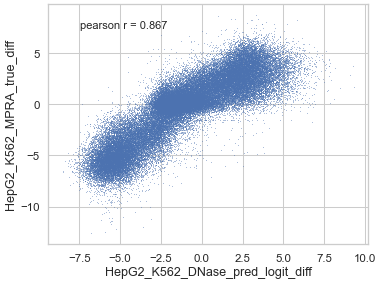

In [16]:
plot_logit_diff(main_df, 'HepG2', 'K562', 'DNase')
plot_logit_diff(main_df, 'HepG2', 'SKNSH', 'DNase')
plot_logit_diff(main_df, 'K562', 'SKNSH', 'DNase')